# Estimate fossil fuel sensitivity

Use a Monte Carlo method to model the fossil fuel uncertainty

In [1]:
import os, glob
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.obs import get_obs
from acrg.name.name import open_ds

import apo_emiss_func, apo_funcs, apo_plot_info

/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
year = 2015
months = [8, 12]
site = 'WAO'
# number of sigma to use on plots
sigma = 3

oxidative_ratio_bio = 1.07
# assumed uncertainty in fossil fuel, per cent
ff_uncertainty = 10
# number of values to use in Monte Carlo
number = 1e3

ocean_o2_model = 'nemo'
# figre fontsize
fontsize = 16

# Gget datetimes for the start and dates of the months above
start_dates = {month: datetime(year, month, 1) for month in months}
end_dates = {month: start_date + relativedelta(months=1, seconds=-1) for month, start_date in start_dates.items()}
date_strs = {month: f'{year}{str(month).zfill(2)}' for month in months}

## Model APO
### Import the timeseries data

Import the pre-run forward models for all APO components

In [3]:
ts_data = apo_funcs.get_timeseries(sites = [site],
                                   sources = ['bc', 'ff', 'ocean',],
                                   year = year)
ts_data = {month: ts_data[site].sel(time=slice(start, end_dates[month]))
           for month, start in start_dates.items()}

Finding timeseries for WAO
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2015.nc']
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2015.nc']

Dropping variables: 
['delta_o2_n2_bc', 'co2_ocean_ecco_mth', 'o2_ocean_ecco_mth', 'co2_ocean_nemo_mth', 'o2_ocean_nemo_mth']

Data variables: 
['apo_bc', 'co2_bc', 'o2_bc', 'apo_adjusted_bc', 'co2_ff', 'o2_ff', 'co2_ocean_ecco', 'o2_ocean_ecco', 'co2_ocean_jena', 'o2_ocean_jena', 'co2_ocean_nemo', 'o2_ocean_nemo', 'n2_ocean_nemo']
---------------------------



/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libLerc.so.4: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


### Model the APO

In [4]:
apo_model = {month: apo_emiss_func.apo(ocean_o2 = ts_month[f'o2_ocean_{ocean_o2_model}'],
                                       ff_co2 = ts_month.co2_ff,
                                       ocean_co2 = ts_month.co2_ocean_nemo,
                                       ocean_n2 = ts_month.n2_ocean_nemo,
                                       ff_o2 = ts_month.o2_ff,
                                       oxidative_ratio_bio = oxidative_ratio_bio,
                                       mf_o2 = 1/6.04,
                                       convert = False) + ts_month.apo_adjusted_bc
             for month, ts_month in ts_data.items()}

### Import the obs data

In [5]:
apo_obs = {month: get_obs(['WAO'], 'apo', start, end_dates[month], keep_missing=True)['WAO'][0].mf
           for month, start in start_dates.items()}

Assuming status flag = 0 for all sites
Getting apo data for WAO...
... changing species from apo to APO
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20230213.nc
... slicing from 2015-08-01 00:00:00 to 2015-08-31 23:59:58.999999999
Assuming status flag = 0 for all sites
Getting apo data for WAO...
... changing species from apo to APO
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20230213.nc
... slicing from 2015-12-01 00:00:00 to 2015-12-31 23:59:58.999999999


## Run the Monte Carlo

Create a random array of uncertainties to apply to the flux estimates

We will create an APO model for each value in this array, adjusting the ffCO2 by the uncertainty value.

In [6]:
# create random array of fossil fuel uncertainties
unc_array = np.random.normal(loc = 0,
                             scale = ff_uncertainty * 1e-2,
                             size = int(number))

# zeros arrays to fill with the timeseries for each uncertainty value
apo_test = {month: np.zeros((int(number), int(len(ts_month.time))))
            for month, ts_month in ts_data.items()}
# the difference between the original model and that with some altered ffCO2
apo_diff = {month: np.zeros_like(apo_month) for month, apo_month in apo_test.items()}

for month, ts_month in ts_data.items():
    for uu, unc in enumerate(unc_array):
        # create a timeseries with the ffCO2 adjusted
        apo_test[month][uu,:] = apo_emiss_func.apo(ff_co2 = ts_month.co2_ff * unc,
                                                   ocean_co2 = ts_month.co2_ocean_nemo,
                                                   ocean_o2 = ts_month[f'o2_ocean_{ocean_o2_model}'],
                                                   ocean_n2 = ts_month.n2_ocean_nemo,
                                                   ff_o2 = ts_month.o2_ff * unc,
                                                   oxidative_ratio_bio = oxidative_ratio_bio,
                                                   mf_o2=1/6.04,
                                                   convert = False)
        # get the difference between this model and the original
        apo_diff[month][uu,:] = apo_model[month] - apo_test[month][uu]

## See what it looks like

Plot the model with the uncertainty as shading

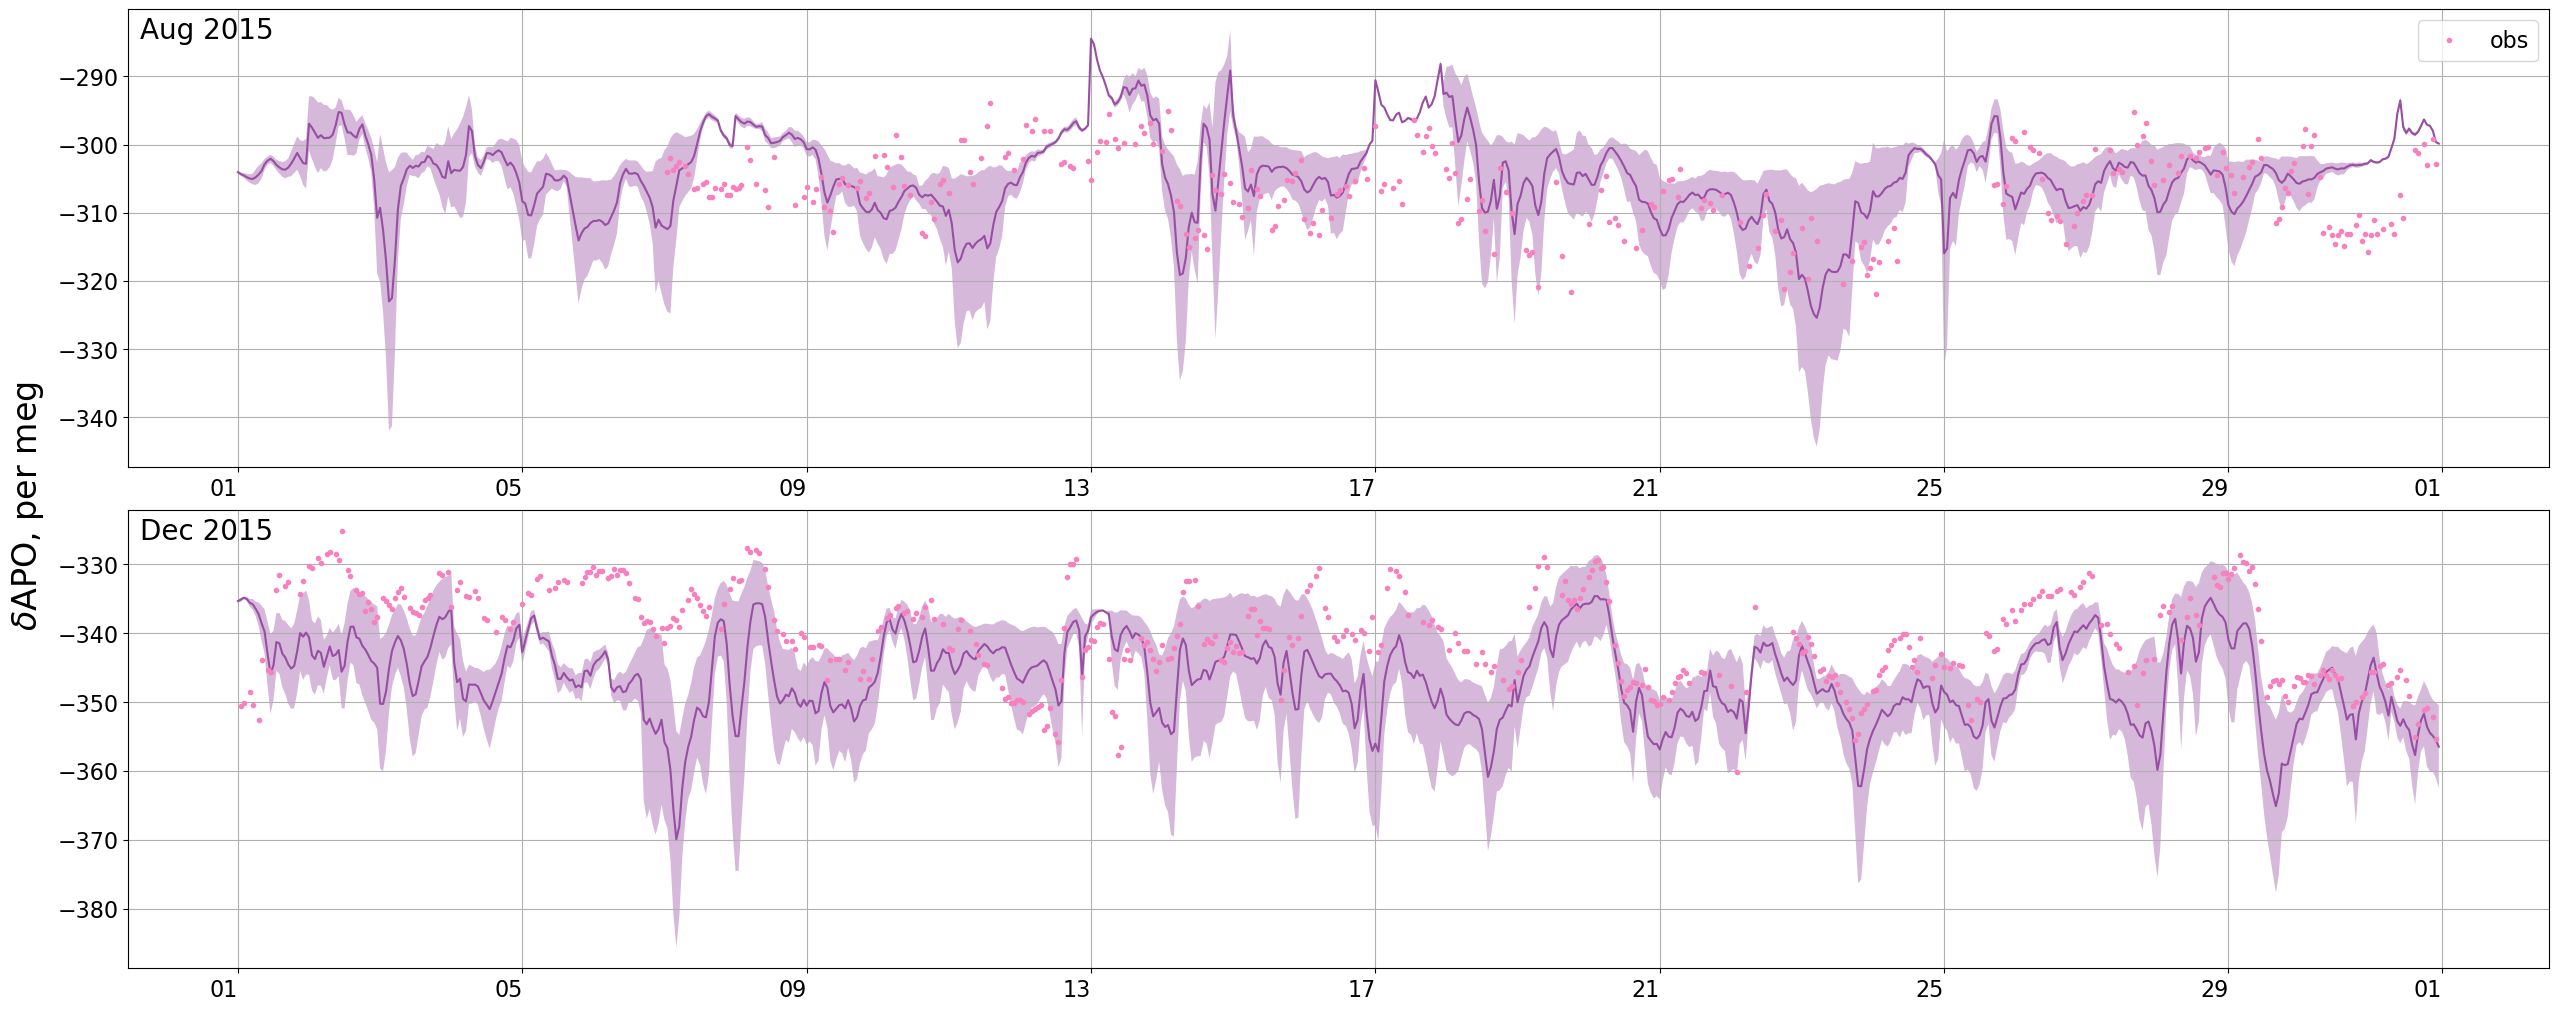

In [7]:
# get the timeseries standard deviation
apo_uncertainty = {month: xr.DataArray(data = apo_test[month].std(axis=0),
                                       coords = {'time': ts_month.time},
                                       dims = ['time'])
                   for month, ts_month in ts_data.items()}

# get the uncertainty by multiiplying by the specified number of sigma
apo_uncertainty_sigma = {month: sigma * apo_month for month, apo_month in apo_uncertainty.items()}

fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, 5*len(months)), constrained_layout=True)

for mm, (month, apo_month) in enumerate(apo_model.items()):
    # add the uncertainty as shading
    unc_plot = axes[mm].fill_between(apo_month.time,
                                     apo_month - apo_uncertainty_sigma[month],
                                     apo_month + apo_uncertainty_sigma[month],
                                     facecolor=apo_plot_info.colors[ocean_o2_model],
                                     alpha=0.4)
    # plot the model
    apo_plot = apo_month.plot(ax=axes[mm], color=apo_plot_info.colors[ocean_o2_model])
    # plot the observations
    obs_plot = apo_obs[month].plot(ax=axes[mm], color=apo_plot_info.colors['obs'],
                                   label='obs', marker='.', ls='none')

# format the tick labels
if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       # add text to show the month and year
       text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]
ticks = [ax.tick_params(labelsize=fontsize) for ax in axes]

grid = [ax.grid() for ax in axes]
legend = axes[0].legend(loc='best', fontsize=fontsize)

# format the axis labels
xlab = [ax.set_xlabel('') for ax in axes]
ylab = [ax.set_ylabel('', fontsize=fontsize+2) for ax in axes]          # remove ylabels
ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=24) # add combines ylabel

# filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'Sensitivity', f'APO_timeseries_ORbio_sensitivity_{sigma}sigma_{date_str}.png')
# print(f'Saving to {filename}')

## Save to netcdf

We save the uncertainty to a netcdf file.

This file contains the uncertainty from our range of tests.

In [8]:
# get the uncertainties file
uncertainty_filenames = {month: os.path.join('/user', 'work', 'vf20487', 'Sensitivities', f'APO_uncertainties_{date_month}.nc')
                         for month, date_month in date_strs.items()}

# define the sttributes to add to the ffCO2 uncertainty variable
attrs = {'units': 'per meg',
         'sigma': 1,
         'description': 'uncertainty associate with the fossil fuel flux estimates, a Monte Carlo run on the CO2 and O2 timeseries',
         'distribution mean': '0 per cent',
         'distribution standard deviation': f'{ff_uncertainty} per cent',
         'Monte Carlo number of runs': number}

for month, uncertainty_filename in uncertainty_filenames.items():
    if os.path.isfile(uncertainty_filename):
        # if the file already exists then open it and update the variable
        print(f'Opening ff uncertainty file to update ff uncertainty variable')
        print(uncertainty_filename)
        apo_uncertainty_ds = open_ds(uncertainty_filename)
        apo_uncertainty_ds[f'ff_{ocean_o2_model}'] = apo_uncertainty[month]
    else:
        # if the file doesn't exist, convert the uncertainty to a dataset
        print(f'Saving ff uncertainty to file: {uncertainty_filename}')
        apo_uncertainty_ds = apo_uncertainty[month].to_dataset(name=f'ff_{ocean_o2_model}')

    # update the variable attributes
    apo_uncertainty_ds[f'ff_{ocean_o2_model}'] = apo_uncertainty_ds[f'ff_{ocean_o2_model}'].assign_attrs(attrs)

    # the file also contains timeseries for the APO models which we can update here
    if f'model_{ocean_o2_model}' not in apo_uncertainty_ds.data_vars:
        attrs_model = {'units': 'per meg',
                    'ocean o2 model': ocean_o2_model}
        apo_uncertainty_ds[f'model_{ocean_o2_model}'] = apo_model[ocean_o2_model]
        apo_uncertainty_ds[f'model_{ocean_o2_model}'] = apo_uncertainty_ds[f'model_{ocean_o2_model}'].assign_attrs(attrs_model)

    # save to netcdf
    apo_uncertainty_ds.to_netcdf(uncertainty_filename)

Opening ff uncertainty file to update ff uncertainty variable
/user/work/vf20487/Sensitivities/APO_uncertainties_201508.nc
Opening ff uncertainty file to update ff uncertainty variable
/user/work/vf20487/Sensitivities/APO_uncertainties_201512.nc
